# Boston Housing Regression

In [1]:
import keras
from keras.datasets import boston_housing

In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
print(train_data.shape, test_data.shape)

(404, 13) (102, 13)


In [5]:
import numpy as np
# 소수점 4자리까지 표시하고, 과학적 표기법(e) 사용하지 않도록 설정
np.set_printoptions(precision=3, suppress=True)

print(train_data[0:2])

[[  1.232   0.      8.14    0.      0.538   6.142  91.7     3.977   4.
  307.     21.    396.9    18.72 ]
 [  0.022  82.5     2.03    0.      0.415   7.61   15.7     6.27    2.
  348.     14.7   395.38    3.11 ]]


In [10]:
print(train_targets[0:2])

[15.2 42.3]


## 데이터 정규화

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [7]:
print(train_data[:2], test_data[:2])

[[-0.272 -0.484 -0.436 -0.257 -0.165 -0.176  0.813  0.117 -0.626 -0.595
   1.149  0.448  0.825]
 [-0.403  2.992 -1.334 -0.257 -1.215  1.894 -1.91   1.248 -0.856 -0.348
  -1.718  0.432 -1.329]] [[ 1.554 -0.484  1.028 -0.257  1.038  0.235  1.11  -0.94   1.676  1.565
   0.784 -3.485  2.251]
 [-0.392 -0.484 -0.161 -0.257 -0.088 -0.499  0.856 -0.684 -0.396  0.157
  -0.308  0.427  0.479]]


In [8]:
from keras import layers
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(
        optimizer="rmsprop",
        loss="mse",
        metrics=["mae"]
    )
    return  model

In [11]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()

    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold #0


2025-01-10 17:17:04.793880: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-01-10 17:17:04.793936: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-10 17:17:04.793949: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-10 17:17:04.794376: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-10 17:17:04.794403: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-01-10 17:17:05.515254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Processing fold #1
Processing fold #2
Processing fold #3


In [12]:
all_scores

[4.029843807220459, 3.7359619140625, 5.687718868255615, 8.1809663772583]

In [13]:
np.mean(all_scores)

5.408622741699219

In [14]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()

    history = model.fit(partial_train_data, partial_train_targets,
    validation_data=(val_data, val_targets),
    epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


In [15]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

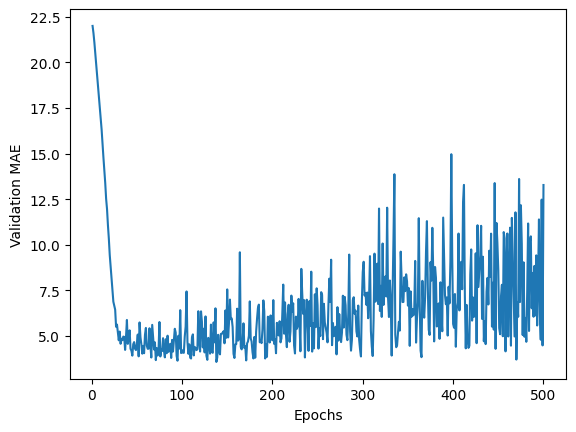

In [16]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

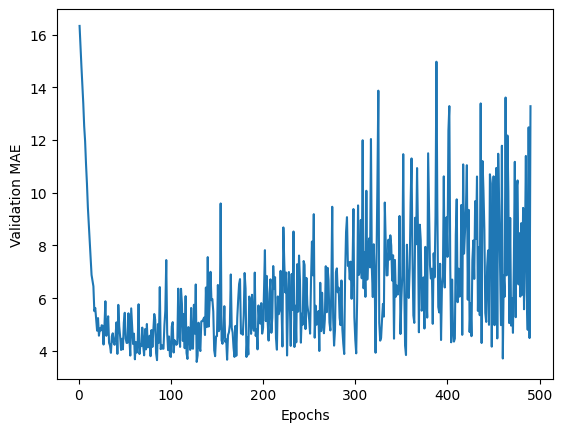

In [17]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [18]:
model = build_model()

model.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 16.6115 - mae: 3.1296


In [19]:
predictions = model.predict(test_data)
predictions[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


array([8.947], dtype=float32)